# Table of Contents
* [Submitting HITs](#Submitting-HITs)
	* [Building URLs for images on s3](#Building-URLs-for-images-on-s3)
	* [submitting HITs in groups](#submitting-HITs-in-groups)
* [Reviewing HITs](#Reviewing-HITs)
	* [Looking at worker breakdown](#Looking-at-worker-breakdown)
* [HIT end-of-life](#HIT-end-of-life)
	* [Pickle Results for temp storage](#Pickle-Results-for-temp-storage)
	* [Careful with these](#Careful-with-these)


In [259]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

In [323]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
plt.rcParams['figure.figsize'] = (16.0, 10.0)

In [230]:
import pickle
import boto
import json
import os
from copy import deepcopy
import boto.mturk.connection as tc
import boto.mturk.question as tq
from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes

import pdfextraction.amt_boto_modules as amt_util

In [430]:
import re
from datetime import datetime
import dateutil.parser as dt_parse

# Submitting HITs

## Building URLs for images on s3

In [202]:
book_groups,ranges = amt_util.load_book_info()

daily_sci_urls = amt_util.make_book_group_urls(book_groups, 'daily_sci', ranges)
spectrum_sci_urls = amt_util.make_book_group_urls(book_groups, 'spectrum_sci', ranges)

## submitting HITs in groups

In [207]:
sandbox_host = 'mechanicalturk.sandbox.amazonaws.com' 
real_world_host = 'mechanicalturk.amazonaws.com'
mturk = tc.MTurkConnection(
    aws_access_key_id = aws_tokes.access_key,
    aws_secret_access_key = aws_tokes.access_secret_key,
    host = real_world_host,
    debug = 1 # debug = 2 prints out all requests.
)
mturk.get_account_balance() # a reminder of sandbox

[$408.35]

In [353]:
static_params = {
    'title': "Annotate Science Textbook",
    'description': "Choose which category text from a grade-school science book best belongs to",
    'keywords': ['image', 'science', 'text', 'labeling' ],
    'frame_height': 800,
    'amount': 0.06,
    'duration': 3600 * 24 *3,
    'max_assignments': 3
}

### creates HITs, careful with this one

In [477]:
len(daily_sci_urls) -500

609

In [206]:
# amt_util.create_hits_from_pages(mturk, daily_sci_urls[500:], static_params)

uncomment only when running

# Reviewing HITs

In [ ]:
r_hits = amt_util.get_completed_hits(mturk)
assignment_results = amt_util.get_assignments(mturk, r_hits)

In [ ]:
raw_hit_results = amt_util.process_raw_hits(assignment_results)
results_df = amt_util.make_results_df(raw_hit_results)
results_df.head(1)

In [475]:
r_hits_batch_2 = amt_util.get_completed_hits(mturk)
assignment_results_batch_2 = amt_util.get_assignments(mturk, r_hits_batch_2)

In [480]:
raw_hit_results_batch_2 = amt_util.process_raw_hits(assignment_results_batch_2)
results_df_batch_2 = amt_util.make_results_df(raw_hit_results_batch_2)
results_df_batch_2.head(1)

,page,category,hit_id,assignment_id,box_id,worker_id
0,Daily_Science_Grade_5_Evan_Moor_95.jpeg,unlabeled,3L7SUC0TTUV39YP3TW6XPGVKLNK0MP,36AHBNMV1RD0PJD5EDN4M2XUIN3YD5,T8,A333VJ2K6O6R79


In [420]:
atv = assignment_results.values()[0][0]

In [318]:
no_consensus_flag = 'No Consensus'
grouped_by_page = results_df.groupby(['page', 'box_id'])

agg_res = grouped_by_page.agg(pd.DataFrame.mode)
agg_res.drop(['assignment_id', 'page', 'box_id', 'worker_id'], axis=1, inplace=True)
agg_res = agg_res.fillna(no_consensus_flag)
consensus_results_df = agg_res.reset_index()
consensus_results_df.drop('level_2', axis=1, inplace=True)

consensus_results_df.head(1)

,page,box_id,category,hit_id
0,Daily_Science_Grade_3_(Daily_Practice_Books)_E...,T1,unlabeled,3ZRKL6Z1E843IXDTRVRMMHH6KTQSGV


In [490]:
no_consensus_flag = 'No Consensus'
grouped_by_page = results_df_batch_2.groupby(['page', 'box_id'])

agg_res2 = grouped_by_page.agg(pd.DataFrame.mode)
agg_res2.drop(['assignment_id', 'page', 'box_id', 'worker_id'], axis=1, inplace=True)
agg_res2 = agg_res2.fillna(no_consensus_flag)
consensus_results_df_batch_2 = agg_res2.reset_index()
consensus_results_df_batch_2.drop('level_2', axis=1, inplace=True)

consensus_results_df_batch_2.head(1)

,page,box_id,category,hit_id
0,Daily_Science_Grade_3_(Daily_Practice_Books)_E...,T1,unlabeled,3BS6ERDL938VJF55ISNBFRIHPCED6L


In [491]:
res_shape = consensus_results_df_batch_2.shape

In [492]:
consensus_results_df.shape

(15416, 4)

In [493]:
res_shape

(711, 4)

In [494]:
consensus_results_df_batch_2['category'].value_counts() / res_shape[0] *100

unlabeled       45.288326
Question        31.504923
Discussion       6.751055
Definition       4.641350
Header/Topic     4.219409
No Consensus     3.938115
Figure Label     3.656821
Name: category, dtype: float64

In [506]:
consensus_results_df_batch_2['page'][0]

u'Daily_Science_Grade_3_(Daily_Practice_Books)_Evan_Moore_165.jpeg'

In [499]:
amt_util.write_results_df(consensus_results_df_batch_2)

In [495]:
no_consensus_hits = consensus_results_df_batch_2[consensus_results_df['category'] == 'No Consensus']

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [348]:
len(pd.unique(no_consensus_hits['page']))

117

In [497]:
to_review = ['start_seq'] + list(np.random.choice(pd.unique(consensus_results_df_batch_2['page']), size= 20, replace=False))

In [410]:
to_review = ['start_seq'] + list(pd.unique(results_df[results_df['worker_id'] == 'A3HSGURL7PBDIX']['page']))

In [408]:
print(len(to_review))

100

In [498]:
amt_util.review_results(to_review)

## Looking at worker breakdown

number of unique workers

In [329]:
pd.unique(results_df['worker_id']).shape[0]

63

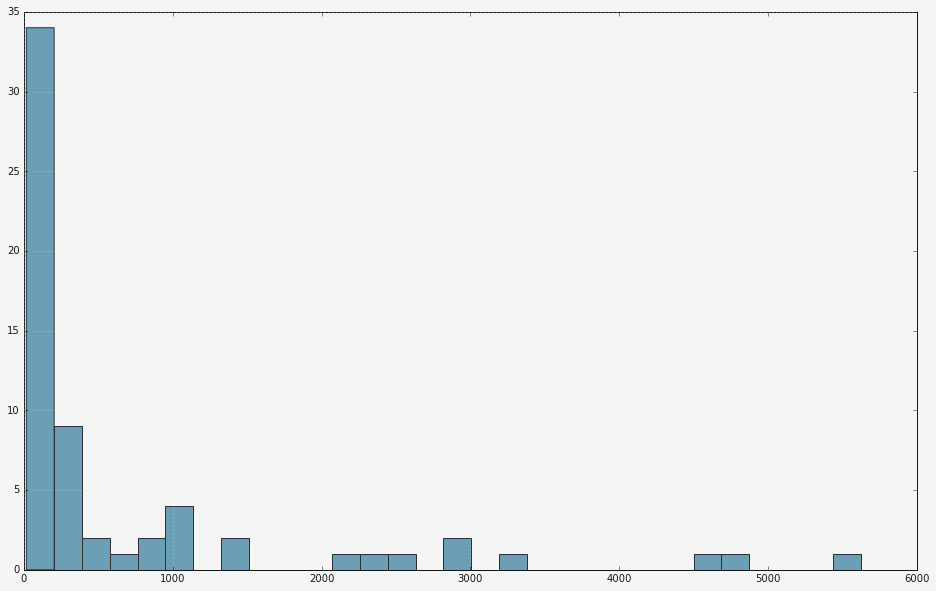

In [325]:
_ = results_df['worker_id'].value_counts().hist(bins= 30)

In [449]:
task_duration_seconds = []
for hit_id, assignments in assignment_results.items():
    for assignment in assignments:
        hit_duration = dt_parse.parse(assignment.SubmitTime) - dt_parse.parse(assignment.AcceptTime)
        task_duration_seconds.append(hit_duration.seconds)

In [454]:
task_duration_series = pd.Series(task_duration_seconds)

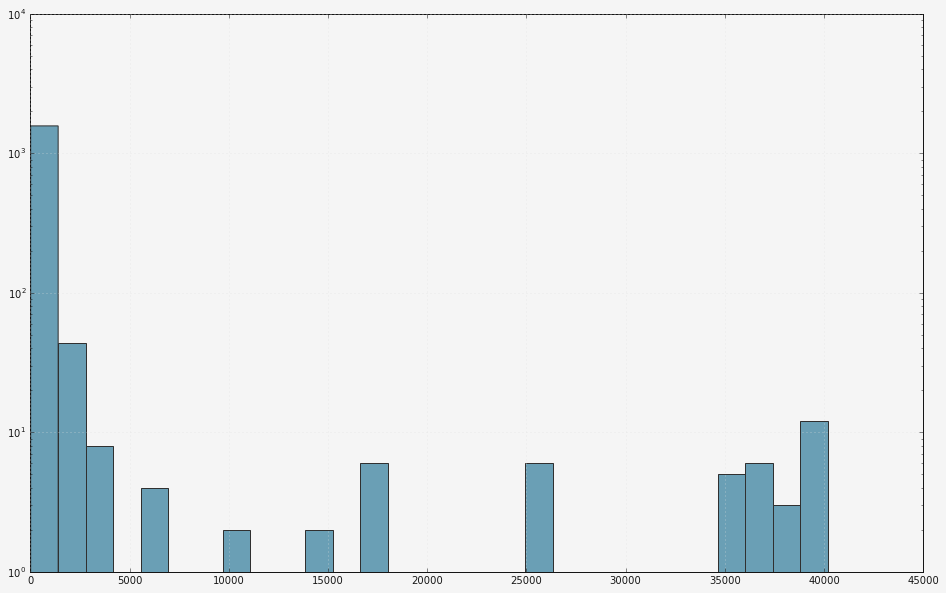

In [457]:
_ = task_duration_series.hist(bins=30, log=True)

In [465]:
winsorized_durations = [t for t in task_duration_seconds if t < 1000]
w_duration_series = pd.Series(winsorized_durations)

In [468]:
w_duration_series.mode()

0    20
1    25
dtype: int64

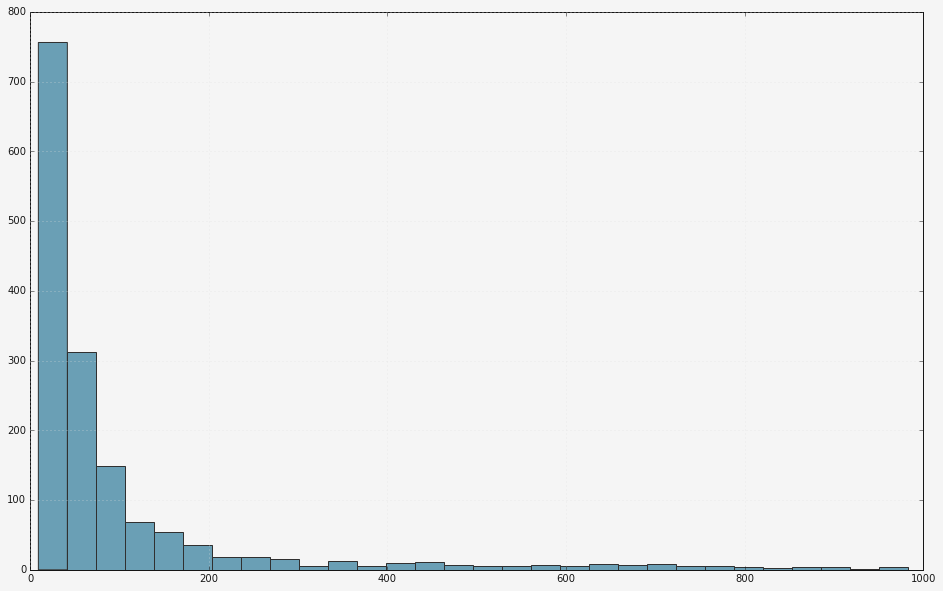

In [466]:
_ = pd.Series(w_duration_series).hist(bins=30)

In [437]:
hit_time = dt_parse.parse(atv.SubmitTime) - dt_parse.parse(atv.AcceptTime)

In [391]:
consensus_with_workerid_df = pd.DataFrame(columns=list(consensus_df.columns) + ['worker_id'])
for hitbox_id, rows in results_df.groupby(['hit_id', 'box_id']):
    this_row = consensus_results_df[(consensus_results_df['hit_id'] == hitbox_id[0]) & (consensus_results_df['box_id'] == hitbox_id[1])]
    new_row = this_row.copy()
    new_row['worker_id'] = rows['worker_id'].values[0]
    new_row['category_this_worker'] = rows['category'].values[0]
    consensus_with_workerid_df = consensus_with_workerid_df.append(new_row)

consensus_with_workerid_df.head(3)

,box_id,category,category_this_worker,hit_id,page,worker_id
5006,T1,unlabeled,unlabeled,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A333VJ2K6O6R79
5007,T10,Discussion,Discussion,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A333VJ2K6O6R79
5008,T11,Question,Question,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A333VJ2K6O6R79


In [393]:
worker_conflicts = consensus_with_workerid_df[consensus_with_workerid_df['category'] != consensus_with_workerid_df['category_this_worker']]
all_worker_counts = results_df['worker_id'].value_counts()
bad_worker_counts = worker_conflicts['worker_id'].value_counts()
worker_quality_df = pd.DataFrame([all_worker_counts, bad_worker_counts]).T
worker_quality_df.columns=['submitted', 'incorrect']
worker_quality_df['hit_perc'] = worker_quality_df['incorrect']/worker_quality_df['submitted']

In [400]:
suspect_workers = worker_quality_df.sort_values('hit_perc', ascending= False).index.tolist()

In [406]:
results_df[results_df['worker_id'].isin(suspect_workers[:10])]

(2318, 6)

In [413]:
to_review = ['start_seq'] + list(np.random.choice(pd.unique(results_df[results_df['worker_id'].isin(suspect_workers[:10])]['page']), size= 50, replace=False))

In [414]:
amt_util.review_results(to_review)

# HIT end-of-life

## Pickle Results for temp storage

In [502]:
temp_store_dir = './store_hit_results_metadata/group'
group_n = '_2/'
try:
    os.mkdir(temp_store_dir + group_n)
except:
    OSError
    
result_file_name = 'hit_info.pkl'
assignment_file_name = 'assignment_info.pkl'
raw_results_file_name = 'raw_res.pkl'
complete_results_file = 'complete_df.pkl'
consensus_results_file = 'consensus_df.pkl'

amt_util.pickle_this(r_hits_batch_2, temp_store_dir + group_n + result_file_name)
amt_util.pickle_this(assignment_results_batch_2, temp_store_dir + group_n + assignment_file_name)
amt_util.pickle_this(raw_hit_results_batch_2, temp_store_dir + group_n + raw_results_file_name)
results_df_batch_2.to_pickle(temp_store_dir + group_n + complete_results_file)
consensus_results_df_batch_2.to_pickle(temp_store_dir + group_n + consensus_results_file)

## Careful with these

In [501]:
# amt_util.accept_hits(mturk, assignment_results_batch_2)

In [200]:
# amt_util.delete_all_hits(mturk)

Uncomment only when ready to accept or delete hits